In [1]:
!pip install pydrake
!pip install drake

In [4]:
from pydrake.symbolic import Variable 
from pydrake.systems.primitives import SymbolicVectorSystem 

# Define a new symbolic Variable 
x = Variable("x")

continuous_vector_system = SymbolicVectorSystem(state=[x], dynamics=[-x+x**3], output=[x])

## Implemented vector system: 

$$x[n+1] = x^{3}[n]$$
$$y[n] = x[n]$$

In [5]:
from pydrake.systems.framework import LeafSystem

# Define the system.
class SimpleContinuousTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.

    # xdot(t) = -x(t) + x^3(t)
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xdot = -x + x**3
        derivatives.get_mutable_vector().SetAtIndex(0, xdot)

# Instantiate the System
continuous_system = SimpleContinuousTimeSystem()


# Define the system.
class SimpleDiscreteTimeSystem(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)  # One state variable.
        self.DeclareStateOutputPort("y", state_index)  # One output: y=x.
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,  # One second time step.
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.

    # x[n+1] = x^3[n]
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)
        x_next = x**3
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)

# Instantiate the System
discrete_system = SimpleDiscreteTimeSystem()

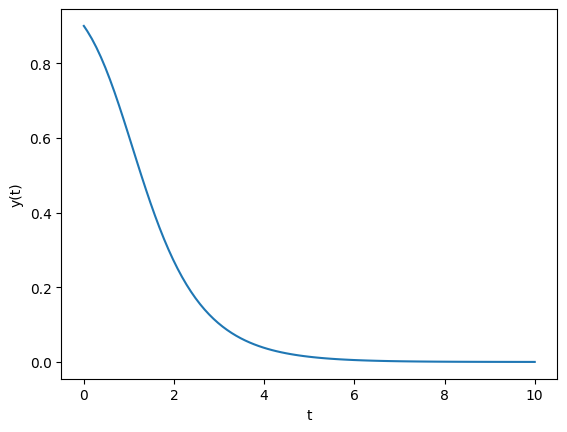

In [6]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator 
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create a simple block diagram containing our system 
builder = DiagramBuilder()
system = builder.AddSystem(SimpleContinuousTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0)
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the result 
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)'); 

Text(0, 0.5, 'y[n]')

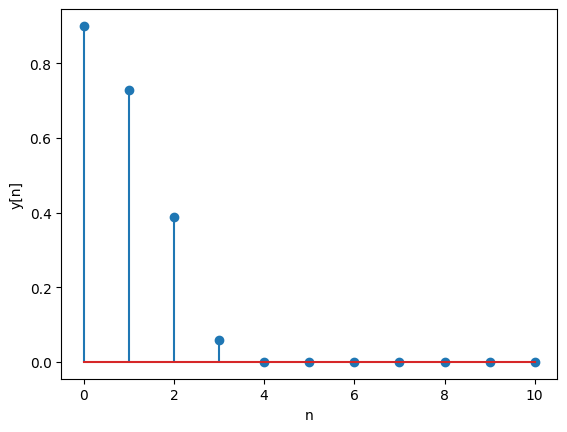

In [5]:
# Create a simple block diagram containing our system 
builder = DiagramBuilder()
system = builder.AddSystem(SimpleDiscreteTimeSystem())
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Create the simulator
simulator = Simulator(diagram)

# Set the initial conditions, x(0)
state = simulator.get_mutable_context().get_mutable_discrete_state_vector()
state.SetFromVector([0.9])

# Simulate for 10 seconds
simulator.AdvanceTo(10)

# Plot the results 
log = logger.FindLog(simulator.get_context())
plt.figure()
plt.stem(log.sample_times(), log.data().transpose())
plt.xlabel('n')
plt.ylabel('y[n]')

`Context` captures all of the (potentially) dynamic information that a `System` requires to implement its core methods: this includes the time, the state, any inputs, and any system parameters. The `Context` of a `System` is everything you need to know for simulation (or control desing, ... and given a `Context` all methods called on a `System` should be completely deterministic/repeatable. 

## Combinations of Systems: Diagram and DiagramBuilder

The real modelling power of Drake comes from combining many smaller systems together into more complex systems. The concept is very simple: we use the `DiagramBuilder` class to `AddSystem()` and to `Connnect()` input ports to output ports or to expose them as inputs/output fo the diagrama. Then we call `Build()` to generate teh new `Diagram` instance, which is just another `System` in the framework, and can be simulated or analyied using the entire suite of tools. In the example below, we connected three subsystems (a plant, a controller, and a logger), and expose the input fo the controller as an input tot he `Diagram` being constructed: 

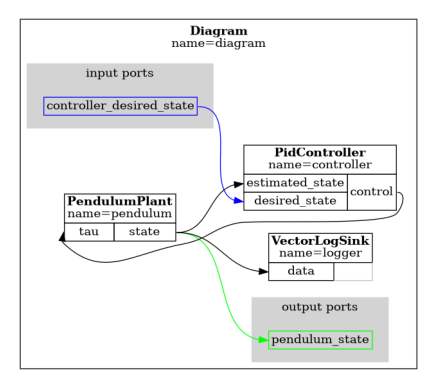

In [6]:
import matplotlib.pyplot as plt 
import numpy as np 
import pydot
from pydrake.examples import PendulumPlant
from pydrake.systems.analysis import Simulator 
from pydrake.systems.controllers import PidController
from pydrake.systems.drawing import plot_system_graphviz
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

# First add the pendulum 
pendulum = builder.AddNamedSystem("pendulum", PendulumPlant())

# Add a PID controller
controller = builder.AddNamedSystem("controller", PidController(kp=[10.], ki=[1.], kd=[1.]))

# Now "wire up" the controller to the plant 
builder.Connect(pendulum.get_state_output_port(), 
                controller.get_input_port_estimated_state())
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port())

# Make the desired_state input of the controller an input to the diagram 
builder.ExportInput(controller.get_input_port_desired_state())
# Make the pendulum state an ouput from the diagram 
builder.ExportOutput(pendulum.get_state_output_port())

# Log the state of the pendulum 
logger = LogVectorOutput(pendulum.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the diagram
plot_system_graphviz(diagram)

Text(0.5, 1.0, 'PID Control of the Pendulum')

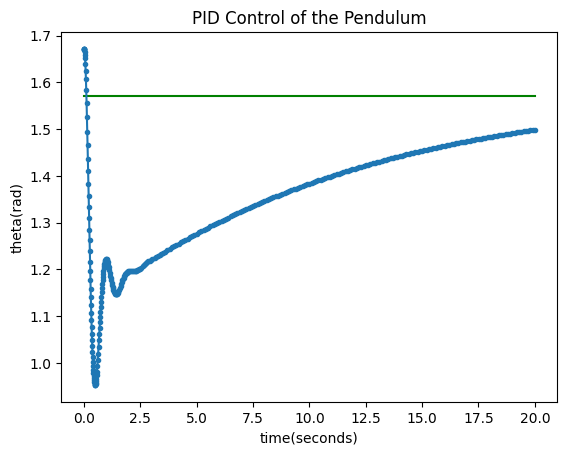

In [7]:
# Set up a simulator to run this diagram 
simulator = Simulator(diagram) 
context = simulator.get_mutable_context() 

# We'll try to regulate the pendulum to a particular angle. 
desired_angle = np.pi/2

# First we extract the subsystem context for the pendulum 
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context) 
# Then we can set the pendulum state, whic is theta, thetadot) 
pendulum_context.get_mutable_continuous_state_vector().SetFromVector(
    [desired_angle + 0.1, 0.2]) 

# The diagram has sa signle input port (port index 0) , which is the desired state 
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# Clear the logger 
logger.FindMutableLog(context).Clear()

# Simulate for 10 seconds 
simulator.AdvanceTo(20); 

# Plot the results 
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta
# Draw a line for the desired angle. 
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g')
plt.plot(t, log.data()[0, :], '.-')
plt.xlabel('time(seconds)')
plt.ylabel('theta(rad)')
plt.title('PID Control of the Pendulum')

### Planar Quadrotor

In [8]:
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import DiagramBuilder, LinearQuadraticRegulator, Simulator

#from underactuated import runnning_as_notebook
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer


#### Install underactuated by MIT 

In [9]:
!pip install --extra-index-url https://drake-packages.csail.mit.edu/whl/nightly underactuated

Looking in indexes: https://pypi.org/simple, https://drake-packages.csail.mit.edu/whl/nightly


In [10]:
from pydrake.systems.drawing import plot_system_graphviz
def planar_quadrotor_example(): 
    def QuadrotorLQR(plant): 
        context = plant.CreateDefaultContext()
        context.SetContinuousState(np.zeros([6, 1]))
        plant.get_input_port(0).FixValue(context, plant.mass * plant.gravity/2.0 * np.array([1, 1]))
        Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2.0 / np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]]) 

        return LinearQuadraticRegulator(plant, context, Q, R)

    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())
    
    controller = builder.AddSystem(QuadrotorLQR(plant))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Setup visualization 
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()
    diagram.set_name("diagram")

    # Visualize the diagram
    plot_system_graphviz(diagram)

    # Set up a simulator to run this diagram 
    simulator = Simulator(diagram) 
    context = simulator.get_mutable_context()

    # Simulate 
    duration = 5.0
    visualizer.start_recording()
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            np.random.randn(
                6,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))
    


done.
generating animation...


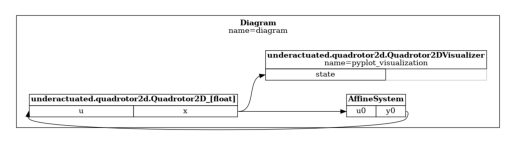

In [12]:
planar_quadrotor_example()

In [13]:
import numpy as np 
from pydrake.all import(
    DiagramBuilder, 
    LinearQuadraticRegulator, 
    MeshcatVisualizer,
    MultibodyPlant, 
    Parser, 
    Propeller, 
    PropellerInfo, 
    RigidTransform, 
    RobotDiagramBuilder, 
    SceneGraph, 
    Simulator, 
    StartMeshcat, 
    namedview, 
)

from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController

## Quadrotor tutorial 

* [Intro quadrotor tutorial](https://deepnote.com/workspace/Underactuated-2ed1518a-973b-4145-bd62-1768b49956a8/project/096cffe7-416e-4d51-a471-5fd526ec8fab/notebook/quadrotor-ac8fa093ca5a4894a618ada316f2750b)

In [14]:
from underactuated import running_as_notebook
from underactuated.scenarios import AddFloatingRpyJoint

In [15]:
# Start the visualizer (run this cell onyl once, each instance consumes a port) 
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [16]:
def quadrotor_example():
    builder = DiagramBuilder()

    plant = builder.AddSystem(QuadrotorPlant())

    controller = builder.AddSystem(StabilizingLQRController(plant, [1, 3, 1]))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.0)
        context.SetContinuousState(
            0.5
            * np.random.randn(
                12,
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(4.0 if running_as_notebook else 0.1)

quadrotor_example()

## TODO: 
- [ ] How to change controller input?
- [ ] How to connect pendulum and quadrotor (maybe first test with the planar quadrotor)?
- [ ] How to put some siĐmple manipulator (acrobot, smthng like that on the quadrotor) 

In [17]:
import pydrake
print(dir(pydrake.examples))

['AcrobotGeometry', 'AcrobotInput', 'AcrobotParams', 'AcrobotPlant', 'AcrobotSpongController', 'AcrobotState', 'CompassGait', 'CompassGaitContinuousState', 'CompassGaitGeometry', 'CompassGaitParams', 'CreateClutterClearingYcbObjectList', 'CreateManipulationClassYcbObjectList', 'IiwaCollisionModel', 'ManipulationStation', 'ManipulationStationHardwareInterface', 'PendulumGeometry', 'PendulumInput', 'PendulumParams', 'PendulumPlant', 'PendulumState', 'QuadrotorGeometry', 'QuadrotorPlant', 'RigidTransform', 'RimlessWheel', 'RimlessWheelContinuousState', 'RimlessWheelGeometry', 'RimlessWheelParams', 'RollPitchYaw', 'SchunkCollisionModel', 'SpongControllerParams', 'StabilizingLQRController', 'VanDerPolOscillator', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_xyz_rpy_deg', 'kBox', 'kBoxCollision', 'kBoxPlusFingertipSpheres', 'kNoCollision', 'np']


## Acrobot 

In [1]:
import numpy as np
from pydrake.all import (
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
)
from pydrake.examples import AcrobotGeometry, AcrobotInput, AcrobotPlant, AcrobotState

from underactuated import running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [ ]:
def acrobot_demo(): 
    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())
    # Setup visualization 
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4) 
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # Setup slider input
    meshcat.AddSlider(
         "u", 
         min=-5, 
         max=5, 
         step=0.1, 
         value=0.0, 
        decrement_keycode="ArrowLeft", 
        increment_keycode="ArrowRight", 
    )
    torque_system = builder.AddSystem(MeshcatSliders(meshcat, ["u"]))
    builder.Connect(torque_system.get_output_port(), acrobot.get_input_port())

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Set up simulator to run this diagram
    context.SetContinuousState([1, 0, 0, 0])

    if running_as_notebook: # Then we're not just running as a test on CI
        simulator.set_target_realtime_rate(1.0)

        print("Use the slider in the MeshCat controls to apply elbow torque.") 
        print("Press 'Stop Simulation' in MeshCat to continue.") 
        meshcat.AddButton("Stop Simulation")
        while meshcat.GetButtonClicks("Stop Simulation") < 1: 
            simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    else: 
        simulator.AdvanceTo(0.1) 
    meshcat.DeleteAddedControls()

acrobot_demo()
    
    

Use the slider in the MeshCat controls to apply elbow torque.
Press 'Stop Simulation' in MeshCat to continue.


In [ ]:
def UprightState(): 
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.0) 
    state.set_theta1dot(0.0)
    state.set_theta2dot(0.0)
    return state

In [ ]:
def acrobot_controllability(): 
    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.0)
    acrobot.get_input_port(0).FixValue(context,input)

    context.get_mutable_continuous_state_vector().SetFromVector(
        UprightState().CopyToVector()
    )

    linearized_acrobot = Linearize(acrobot, context)
    print(
        f"The singular values of the controllability matrix are {np.linalg.svd(ControllabilityMatrix(linearized_acrobot), compute_uv=False)}"
    )

acrobot_controllability()

In [20]:
def acrobot_balancing_example(): 
    def BalancingLQR(): 
        # Design an LQR controller for stabilizing the Acrobot around the upright. 
        # Returns a (static) AffineSystem that implements the controller
        # the original AcrobotState coordinates). 

        acrobot = AcrobotPlant()
        context = acrobot.CreateDefaultContext()
        input = AcrobotInput()
        input.set_tau(0.0)
        acrobot.get_input_port(0).FixValue(context, input)
        context.get_mutable_continuous_state_vector().SetFromVector(
            UprightState().CopyToVector()
        )
        Q = np.diag((10.0, 10.0, 1.0, 1.0))
        R = [1] 
        return LinearQuadraticRegulator(acrobot, context, Q, R)

    builder = DiagramBuilder()
    acrobot = builder.AddSystem(AcrobotPlant())

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(0, 0, 2.0 * np.pi)
    wrapangles.set_interval(1, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles) 
    builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(BalancingLQR())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    # Setup visualization 
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
    meshcat.Delete()
    meschat.Set2dRenderMode(xmin=-4, xmax=4, ymin=-4, ymax=4)
    MeschatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram 
    simulator = Simulator(diagram) 
    context = simulator.get_mutable_context()

    # Simulate 
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    duration = 4.0 if running_as_notebook else 0.1 
    for i in range(5): 
        context.SetTime(0.0) 
        context.SetContinuouusState(
            UprightState().CopyToVector()
            + 0.05
            + np.random.randn(
                4, 
            )
        )
        simulator.Initialize()
        simulator.AdvanceTo(duration)

acrobot_balancing_example()

SystemExit: Failure at systems/framework/diagram_builder.cc:451 in ThrowIfInputAlreadyWired(): condition 'iter != input_port_ids_.end()' failed.

# Animate 2D pendulum wth Drake 

Question is how to connect pendulum and the quad?

2D planar quadrotor is already modeled. How to model pendulum, and how to asign pendulum to the 2D planar quadrotor. 

## How to write custom system? 

Two methods: 
1. `pydrake.systems.framework.LeafSystem`
2. `pydrake.systems.primitives.SymbolicVectorSystem`

For more complicated systems, the LeafSystem is recommended. But in this example we will be simualting a simple pendulum, and using the `SymbolicVectorSystem` will be the most straightforward. 

As the name sugests, this methods uses DRAKE's symbolic engine. 

Pendulum state-space representation: 

$$ x_1 = \theta \rightarrow \dot{x}_1 = x_2 $$
$$ x_2 = \dot{\theta} \rightarrow \dot{x}_2 = \frac{-g}{L}sin(x_1) + \frac{u(t)}{mL^2} $$ 

## How to simulate a system?

In [9]:
# Import Libraries: 
import pydrake.symbolic 
from pydrake.symbolic import Variable 
from pydrake.systems.primitives import SymbolicVectorSystem 

# Parameters 
g = 9.81
L = 1

# Define Symbolic Variables: States = [theta, dtheta]
th = Variable("th")
dth = Variable("dth")

# States and State-space Form: 
states = [th, dth] 
odes = [dth, -g/L * pydrake.symbolic.sin(th)]

# Define the system
continuous_vector_system = SymbolicVectorSystem(state = states, dynamics = odes, output=states)

In [10]:
import numpy as np
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

# Create Block Diagram containing out system: 
builder = DiagramBuilder()
system = builder.AddSystem(continuous_vector_system)
logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set Initial Comnditions: [theta(0) = pi/4, dtheta(0) = 0]
context = diagram.CreateDefaultContext()
context.SetContinuousState([np.pi / 4.0, 0.0])


In [11]:
# Create Simulator and simulate for 10 seconds: 
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Grab results from Logger: 
log = logger.FindLog(context)
time = log.sample_times()
data = log.data().transpose()
theta = data[:, 0]
dtheta = data[:, 1]

In [12]:
simulation_size = len(time)

# Initialize and Solve Animation States: 
x = np.zeros(simulation_size)
y = np.zeros(simulation_size) 

for i in range(0, simulation_size):
    x[i] = L * np.sin(theta[i])
    y[i] = -L * np.cos(theta[i])

# Find the average timestep of the simulation: 
timesteps = []
average_timestep = 0
for i in range(simulation_size - 1): 
    timestep = abs(time[i] - time[i+1])
    timesteps.append(timestep)

average_timestep = sum(timesteps)/len(timesteps) 

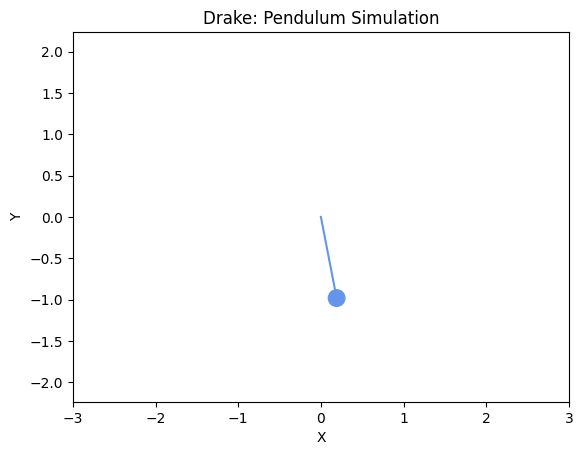

In [19]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle

# Animate Results:
fig, ax = plt.subplots()
p, = ax.plot([],[], color='cornflowerblue') # initializes an empty plot
ax.axis('equal')
ax.set_xlim([-3, 3]) # X Lim
ax.set_ylim([-3, 3]) # Y Lim
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Drake: Pendulum Simulation')
video_title = "pendulum"

# Patch: 
c = Circle((0, 0), radius=0.1, color='cornflowerblue')
ax.add_patch(c)

# Animation Parameters 
FPS = 20
dt = average_timestep
sample_rate = int(1 / (FPS*dt))
dpi = 300
writerObj = FFMpegWriter(fps=FPS)
video_path_1 = "./videos/" + video_title + ".mp4"

# Plot and Create Animation 
with writerObj.saving(fig, video_path_1, dpi): 
    for i in range(0, simulation_size, sample_rate): 
        # Update plot: 
        x_data_points = [0, x[i]]
        y_data_points = [0, y[i]]
        p.set_data(x_data_points, y_data_points)
        # Update Patch: 
        patch_center = x[i], y[i]
        c.center = patch_center
        # Update Drawing
        fig.canvas.draw()
        writerObj.grab_frame()
        

# NOT FINISHED

Control is not implemented! 

# How to connect simple pendulum and the quadrotor: 


- [ ] How to connect pendulum and quadrotor (maybe first test with the planar quadrotor)?
###  Break into smaller steps: 
- [ ] Simulate simple pendulum
- [ ] Check cartpole simulation
- [ ] Connect flat quadrotor with pendulum -> extend to the UAV 3D case

# Simple pendulum in Drake



In [39]:
import numpy as np
from pydrake.all import (
    DiagramBuilder, 
    MeshcatVisualizer, 
    RigidTransform, 
    RotationMatrix, 
    SceneGraph, 
    Simulator, 
    StartMeshcat, 
)

from pydrake.examples import PendulumGeometry, PendulumPlant

from underactuated import running_as_notebook 
from underactuated.meshcat_utils import MeshcatSliders


In [40]:
# Start the visualizer (run this cell only once, each instance comsumes a port) 
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7004


# Dynamics of the simple pendulum 

For the duration of this notebook we will use following dynamics equations for the pendulum: 

$$ ml^2\ddot{\theta} + b\dot{\theta} + mglsin(\theta) = u $$

In [ ]:
def pendulum_simulation(): 
    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())

    # Setup visualization 
    scene_graph = builder.AddSystem(SceneGraph())
    PendulumGeometry.AddToBuilder(
        builder, pendulum.get_state_output_port(), scene_graph
    )
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Delete()
    meshcat.Set2dRenderMode(
        X_WC = RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0])
    )

    # Setup slider input
    meshcat.AddSlider("u", min=-5, max=5, step=0.1, value=0.0)
    torque_system = builder.AddSystem(MeshcatSliders(meshcat, ["u"]))
    builder.Connect(torque_system.get_output_port(), pendulum.get_input_port())

    diagram = builder.Build()

    # Set up a simulator to run this diagram 
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    meshcat.AddButton("Stop Simulation")

    # Set the initial conditions
    context.SetContinuousState([0.5, 0]) #theta, thetadot

    if running_as_notebook: 
        simulator.set_target_realtime_rate(1.0)

        print("Use the slider in the MeshCat controls to apply elbow torque.")
        print("Press 'Stop Simulation' in MeshCat to continue.")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    else:
        simulator.AdvanceTo(0.1)
    meschat.DeleteAddedControls()

pendulum_simulation()
        